**Part 1: Task 1 — Reproduce the sine-wave GAN**

In [1]:
#Imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


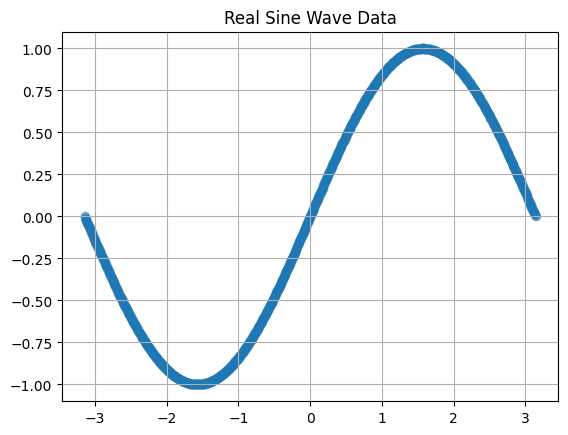

In [2]:
#Generate sine wave data
def generate_sine_wave(n_points=1000):
    x = np.linspace(-np.pi, np.pi, n_points)
    y = np.sin(x)
    data = np.stack([x, y], axis=1).astype(np.float32)
    return data

real_data = generate_sine_wave()
plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.5)
plt.title("Real Sine Wave Data")
plt.grid(True)
plt.show()


In [3]:
#Define simple GAN model (sine wave)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


Epoch 0: D Loss=1.4576, G Loss=0.6733
Epoch 500: D Loss=1.3883, G Loss=0.6727
Epoch 1000: D Loss=1.3636, G Loss=0.6841
Epoch 1500: D Loss=1.3310, G Loss=0.7483


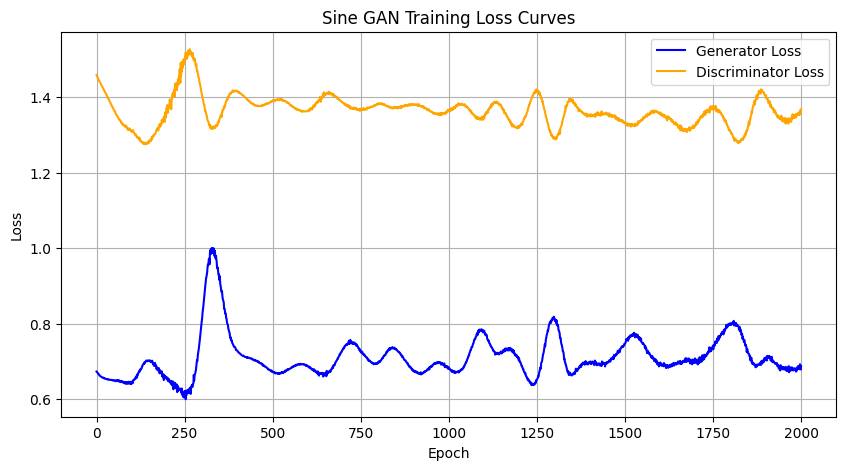

In [4]:
#Train sinne GAN
def train_gan(real_data, generator, discriminator, epochs=2000):
    g = generator.to(device)
    d = discriminator.to(device)

    criterion = nn.BCELoss()
    g_opt = optim.Adam(g.parameters(), lr=0.001)
    d_opt = optim.Adam(d.parameters(), lr=0.001)

    real_data = torch.tensor(real_data).to(device)

    g_losses, d_losses = [], []

    for epoch in range(epochs):
        # Train discriminator
        d_opt.zero_grad()
        real_labels = torch.ones(len(real_data), 1).to(device)
        fake_labels = torch.zeros(len(real_data), 1).to(device)

        outputs_real = d(real_data)
        loss_real = criterion(outputs_real, real_labels)

        noise = torch.randn(len(real_data), 2).to(device)
        fake_data = g(noise)
        outputs_fake = d(fake_data.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = loss_real + loss_fake
        d_loss.backward()
        d_opt.step()

        # Train generator
        g_opt.zero_grad()
        noise = torch.randn(len(real_data), 2).to(device)
        fake_data = g(noise)
        outputs = d(fake_data)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_opt.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: D Loss={d_loss.item():.4f}, G Loss={g_loss.item():.4f}")

    return g, d, g_losses, d_losses

G_sine = Generator()
D_sine = Discriminator()
G_sine, D_sine, g_losses_sine, d_losses_sine = train_gan(real_data, G_sine, D_sine)
#Plot Sine GAN Training Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses_sine, label="Generator Loss", color='blue')
plt.plot(d_losses_sine, label="Discriminator Loss", color='orange')
plt.title("Sine GAN Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



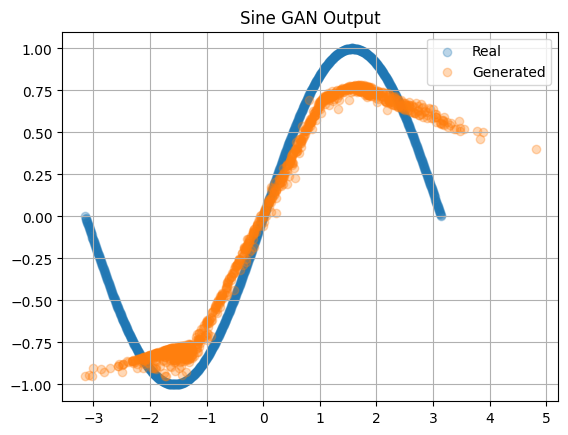

In [5]:
#Plot sine GAN results
with torch.no_grad():
    noise = torch.randn(1000, 2).to(device)
    generated = G_sine(noise).cpu().numpy()

plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.3, label="Real")
plt.scatter(generated[:, 0], generated[:, 1], alpha=0.3, label="Generated")
plt.title("Sine GAN Output")
plt.legend()
plt.grid(True)
plt.show()


**Part 1: Task 2 and 3 — Train and Modify GAN on Spiral Data**

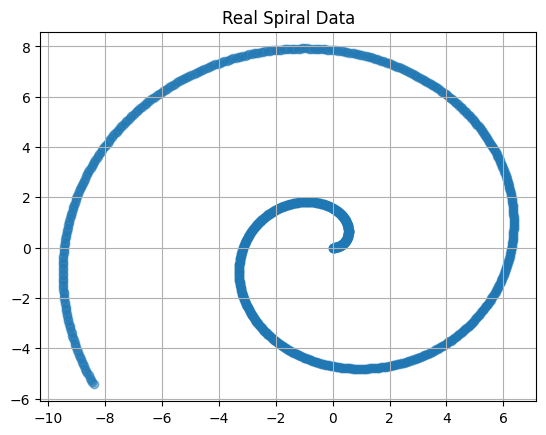

In [6]:
#Generate spiral data
def generate_spiral_data(n_points=1000):
    r = np.linspace(0, 10, n_points)
    x = r * np.cos(r)
    y = r * np.sin(r)
    data = np.stack([x, y], axis=1).astype(np.float32)
    return data

spiral_data = generate_spiral_data()
plt.scatter(spiral_data[:, 0], spiral_data[:, 1], alpha=0.5)
plt.title("Real Spiral Data")
plt.grid(True)
plt.show()


In [7]:
#Modified GAN with deeper architecture and Tanh
class Generator_Modified(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator_Modified(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [8]:
#Train modified GAN on spiral data
G_spiral = Generator_Modified()
D_spiral = Discriminator_Modified()
spiral_data_tensor = torch.tensor(spiral_data).to(device)

G_spiral, D_spiral, g_losses_spiral, d_losses_spiral = train_gan(
    spiral_data_tensor, G_spiral, D_spiral
)


/tmp/ipython-input-1742157914.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_data = torch.tensor(real_data).to(device)


Epoch 0: D Loss=1.5237, G Loss=0.6763
Epoch 500: D Loss=1.3119, G Loss=0.7923
Epoch 1000: D Loss=1.2773, G Loss=0.8178
Epoch 1500: D Loss=1.2715, G Loss=0.7864


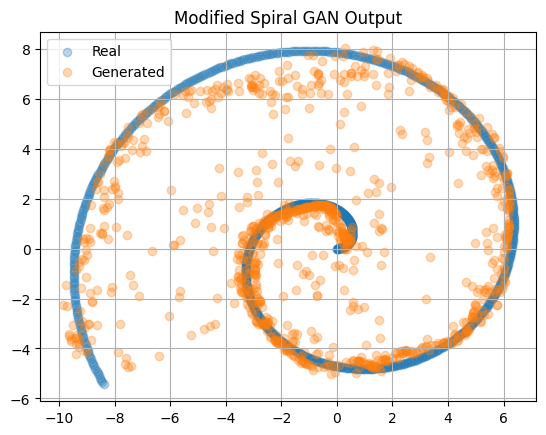

In [9]:
#Plot generated spiral samples
with torch.no_grad():
    noise = torch.randn(1000, 2).to(device)
    generated_spiral = G_spiral(noise).cpu().numpy()

plt.scatter(spiral_data[:, 0], spiral_data[:, 1], alpha=0.3, label="Real")
plt.scatter(generated_spiral[:, 0], generated_spiral[:, 1], alpha=0.3, label="Generated")
plt.title("Modified Spiral GAN Output")
plt.legend()
plt.grid(True)
plt.show()


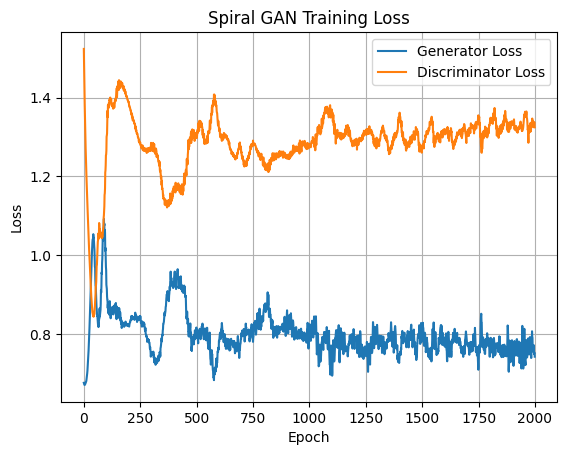

In [10]:
#Plot loss curves for spiral GAN
plt.plot(g_losses_spiral, label="Generator Loss")
plt.plot(d_losses_spiral, label="Discriminator Loss")
plt.title("Spiral GAN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# PART 2: DCGAN for PathMNIST (Medical Imaging)

**Install and Import Libraries**

In [11]:
#Install and import all required libraries
!pip install medmnist --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from medmnist import INFO, PathMNIST
from medmnist import Evaluator

# Set manual seed and device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



**Load and Prepare PathMNIST Dataset**

In [12]:
#Load the dataset
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = PathMNIST

# Transformation: convert image to tensor and normalize between [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load training dataset
train_dataset = DataClass(split='train', transform=transform, download=download)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)



**Visualize Sample Images**

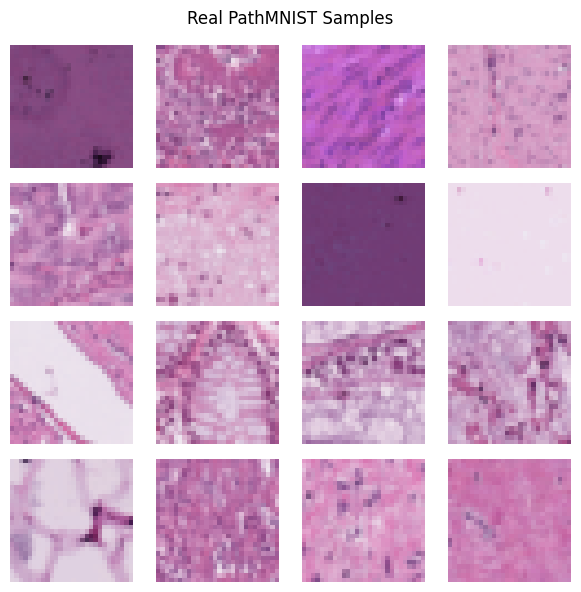

In [13]:
#Plot a few real images from PathMNIST (with denormalization)
def show_samples(dataset, num=16):
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            idx = np.random.randint(len(dataset))
            image = dataset[idx][0]
            image = image * 0.5 + 0.5
            image = image.permute(1, 2, 0)
            axes[i, j].imshow(image)
            axes[i, j].axis("off")
    plt.suptitle("Real PathMNIST Samples")
    plt.tight_layout()
    plt.show()

show_samples(train_dataset)




**DCGAN Architecture Cell (Generator & Discriminator)**

In [14]:
#DCGAN Generator and Discriminator Models

import torch
import torch.nn as nn

# Generator (takes noise and outputs image)
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256 * 7 * 7),
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator (takes image and outputs real/fake)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


**Model Instantiation Cell**

In [15]:
#Initialize Generator and Discriminator

noise_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)


**Loss Function and Optimizers Cell**

In [16]:
#Define loss and optimizers

criterion = nn.BCELoss()

# Use Adam
lr = 0.0002
beta1 = 0.5

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


**Training Parameters Cell**

In [17]:
#Set training parameters

epochs = 50
batch_size = 128
fixed_noise = torch.randn(16, noise_dim, device=device)  # For fixed sample generation


**Training Loop Cell**

In [18]:
#Start training loop

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

losses_G = []
losses_D = []

for epoch in range(epochs):
    for images, _ in train_loader:
        real_imgs = images.to(device)
        batch_size = real_imgs.size(0)

        #Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        optimizer_D.zero_grad()

        outputs_real = discriminator(real_imgs)
        loss_real = criterion(outputs_real, real_labels)

        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = generator(noise)
        outputs_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        outputs = discriminator(fake_imgs)
        loss_G = criterion(outputs, real_labels)
        loss_G.backward()
        optimizer_G.step()

    # Save losses
    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")


Epoch [5/50], Loss_D: 0.0732, Loss_G: 3.9042
Epoch [10/50], Loss_D: 0.1026, Loss_G: 3.7515
Epoch [15/50], Loss_D: 0.6981, Loss_G: 1.3409
Epoch [20/50], Loss_D: 0.0377, Loss_G: 5.7982
Epoch [25/50], Loss_D: 0.0171, Loss_G: 7.1333
Epoch [30/50], Loss_D: 1.8708, Loss_G: 3.4935
Epoch [35/50], Loss_D: 0.6003, Loss_G: 13.0300
Epoch [40/50], Loss_D: 0.2874, Loss_G: 12.4331
Epoch [45/50], Loss_D: 0.2526, Loss_G: 5.6964
Epoch [50/50], Loss_D: 0.0705, Loss_G: 6.4380


**Visualize Fake Images**

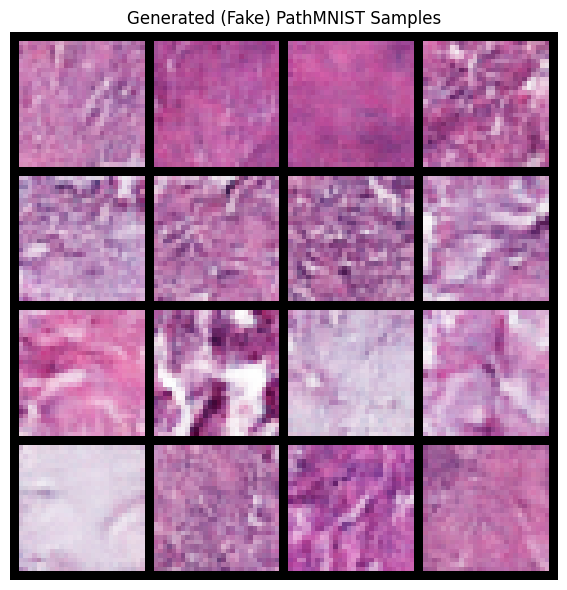

In [19]:
#Generate and display fake images from the trained Generator
from torchvision.utils import make_grid

def show_fake_samples(generator, fixed_noise):
    generator.eval()  # Set to eval mode for inference
    with torch.no_grad():
        fake_images = generator(fixed_noise.to(device)).cpu()

    # Rescale images from [-1, 1] → [0, 1]
    fake_images = (fake_images + 1) / 2

    grid = make_grid(fake_images, nrow=4, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title("Generated (Fake) PathMNIST Samples")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

show_fake_samples(generator, fixed_noise)


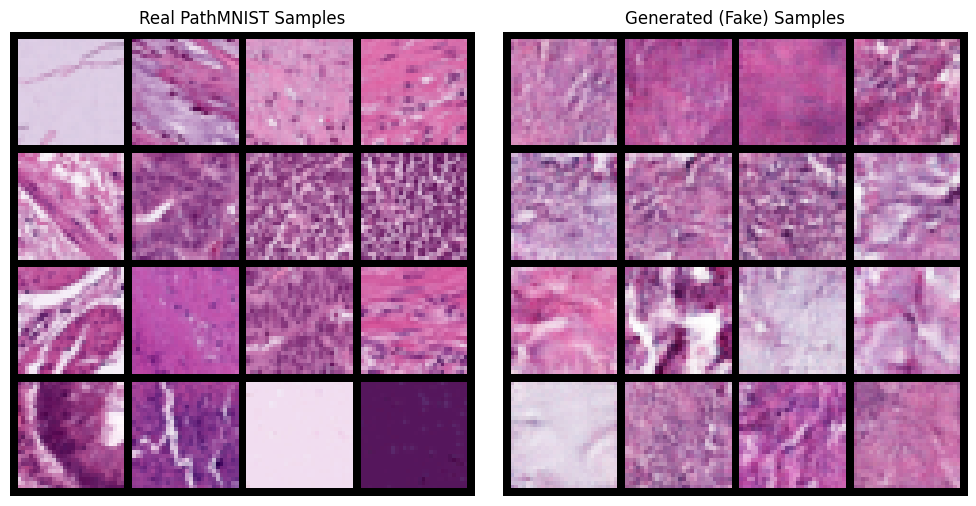

In [20]:
#Side by side comparison: Real vs Fake PathMNIST samples
import torchvision
from torchvision.utils import make_grid

def show_side_by_side(real_dataset, generator, noise):
    # Real images
    real_images = torch.stack([real_dataset[i][0] for i in range(16)])
    grid_real = make_grid(real_images, nrow=4, normalize=True)

    # Fake images
    fake_images = generator(noise).detach().cpu()
    grid_fake = make_grid(fake_images, nrow=4, normalize=True)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(np.transpose(grid_real.numpy(), (1, 2, 0)))
    axs[0].set_title("Real PathMNIST Samples")
    axs[0].axis("off")

    axs[1].imshow(np.transpose(grid_fake.numpy(), (1, 2, 0)))
    axs[1].set_title("Generated (Fake) Samples")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

show_side_by_side(train_dataset, generator, fixed_noise)


**Plot Loss Curves**

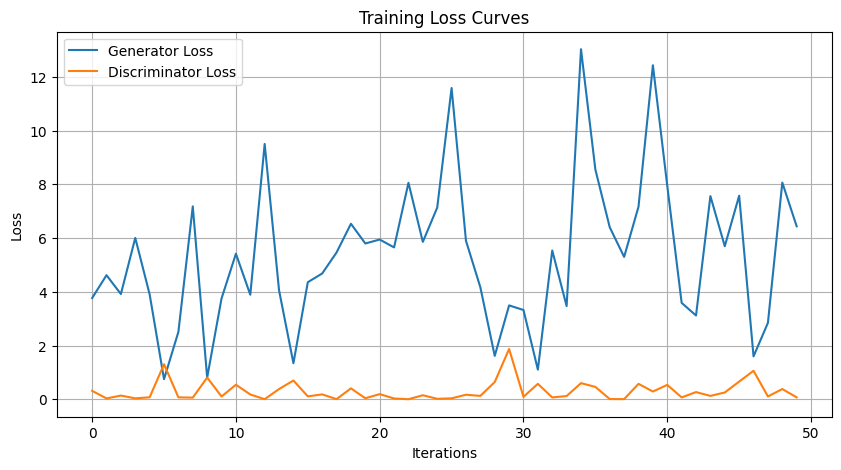

In [21]:
#Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label="Generator Loss")
plt.plot(losses_D, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()
